# This is an examples of how to perform a CGM analysis using the rb_spec.py pipeline


## Written By: Rongmon Bordoloi
----------------

The goal of this notebook is to show a running example analysing absorption line spectra. We will read in a fits file of a HST/COS quasar, pick one absorption line, continuum normalize it locally and then compute the EW and AOD column density of that line. 

This pipeline allows one to do a batch mode continuum normalization or an interactive local continuum normalization


-----------------
Example Created: Feb 11, 2021

Tested on Python 3.7
https://github.com/rongmon/rbcodes

-------------------
## Requirements: 

astropy, numpy, scipy, matplotlib,linetools



linetools for input output of fits files, and for COS LSF



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from GUIs.rb_spec import rb_spec as r
from IGM import rb_setline as setline
from linetools.spectra.xspectrum1d import XSpectrum1D  
from importlib import reload


## Read in the data that you want to measure

In [2]:
filename='example-data/test.fits'
s=r.from_file(filename,filetype='xfits')

Normalizing spectrum using given continuum...


## The transition of the absorber and it's redshift

In [3]:
#Redshift of the absorber you are trying to fit
zabs=0.348
transition=1025.6 # HI 1025 

## Shift spectrum to the rest frame of the absorber

In [4]:
s.shift_spec(zabs);

## Create a small slice of the spectrum that you want to analyze

In [5]:
xlim=[-600,600]
s.slice_spec(transition,xlim[0],xlim[1],use_vel=True);
# Showing the atomic tranistion and its line properties
str1=setline.rb_setline(transition,'closest',linelist='LLS')
str1

{'wave': 1025.7223, 'fval': 0.07912, 'name': 'HI 1025'}

## Fit continuum 

## First we will fit in a non-interactive mode, a Legendre polinomial fit with part of the spectrum masked off

Note: Use only the continuum fitting routine you want. You don't need to use both methods. I am commenting out the non-interactive mode below. But it is presented for psterity.

<p> We mask the part of spectrum that we don't want to fit. </p>
<p>Mask is created to have multiple low vel, high vel ranges.</p>
<p>e.g. mask = [-300.,-250.,100.,120.] will exclude -300,-250 and 100,120 km/s parts of the spectrum in the fit
</p>

Both statistical and continuum fitting error included.


<IPython.core.display.Javascript object>


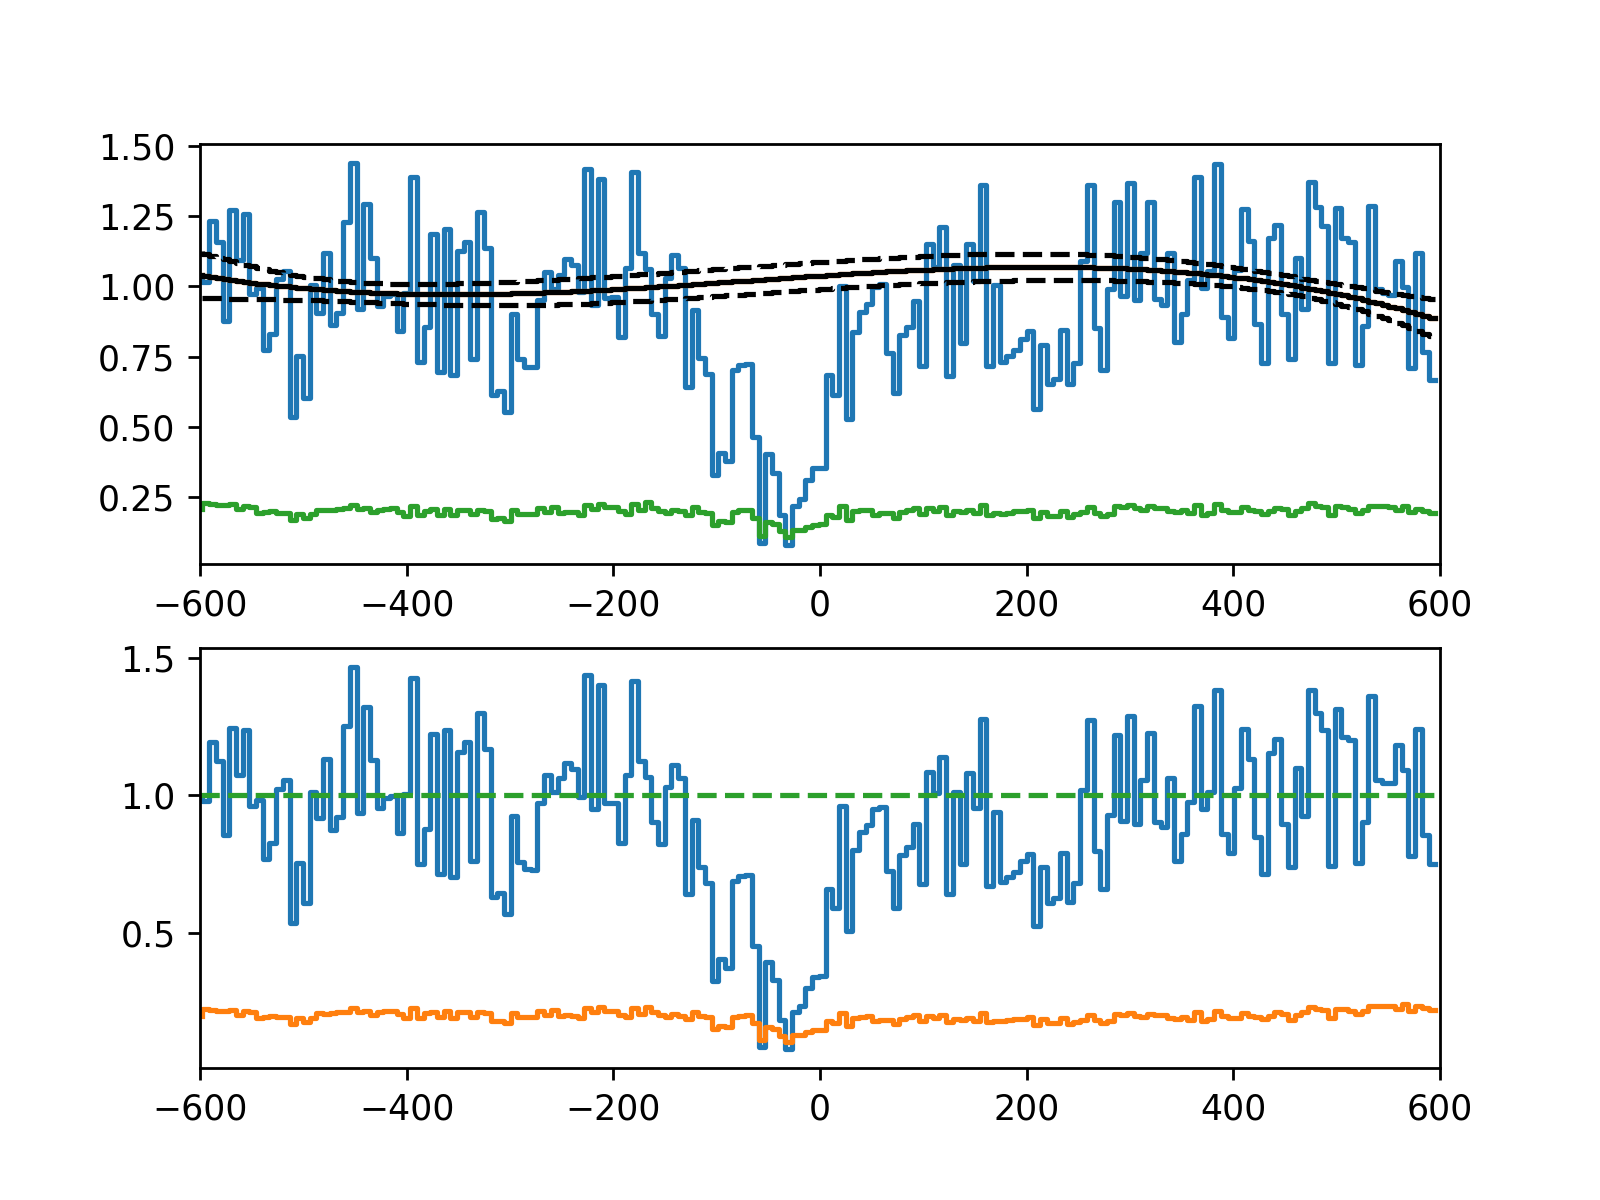

(-600.0, 600.0)

In [6]:
s.fit_continuum(mask=[-560,-500,-330,-230,-170,120.,140.,290.],domain=xlim,Legendre=3)



# Show the fits
plt.subplot(2,1,1)
plt.step(s.velo,s.flux_slice)
plt.step(s.velo,s.flux_slice/s.fnorm)
plt.step(s.velo,s.cont,'k-')
plt.step(s.velo,s.cont+s.cont_err,'k--')
plt.step(s.velo,s.cont-s.cont_err,'k--')
plt.step(s.velo,s.error_slice)
plt.xlim(xlim)
plt.subplot(2,1,2)
plt.step(s.velo,s.fnorm)
plt.step(s.velo,s.enorm)


plt.plot([-600,600],[1,1],'--')
plt.xlim(xlim)


## An alternate method to fit local continuum. 

## Interactive Continuum Fitting.

## ***********************************


<p>The required keystrikes are:</p>



<p>         This calls an interactive continuum fitter for 1D spectrum.
            We will create a spline continuum fit from selected points.
    
            Program sequence is important. First you select the continuum positions using either left mouse button or keystroke b. Right clock will deselect any continuum point. 
    
    Then press 'enter' to fit the continuum. Then press 'n' to show the normalized spectrum.
    
    
            Useful Keystrokes:
    
                Mouse Clicks:
                
                    Left Click  : Select the median flux value within +/- 5 pixel from the x-coordinate.
                                  These points are used for the continuum fit.
                    Right Click : Delete the nearest continuum point.
    
                Keystrokes:
                  
                  b     :    Select a point for continuum fit at that exact (x,y) coordinate.
                  enter :    Perform a spline fit to data to create a continuum.
                  n     :    Show the normalized spectrum.
                  w     :    Only after pressing n: This will ourput the continuum. 
                  h     :    This Help screen.
                  r     :    Reset fit.
                  q     :    Quit Program.
             ---------------------------------------------------------------------------
            Written By:  Rongmon Bordoloi                                   July 13 2017.
    


</p>

<IPython.core.display.Javascript object>


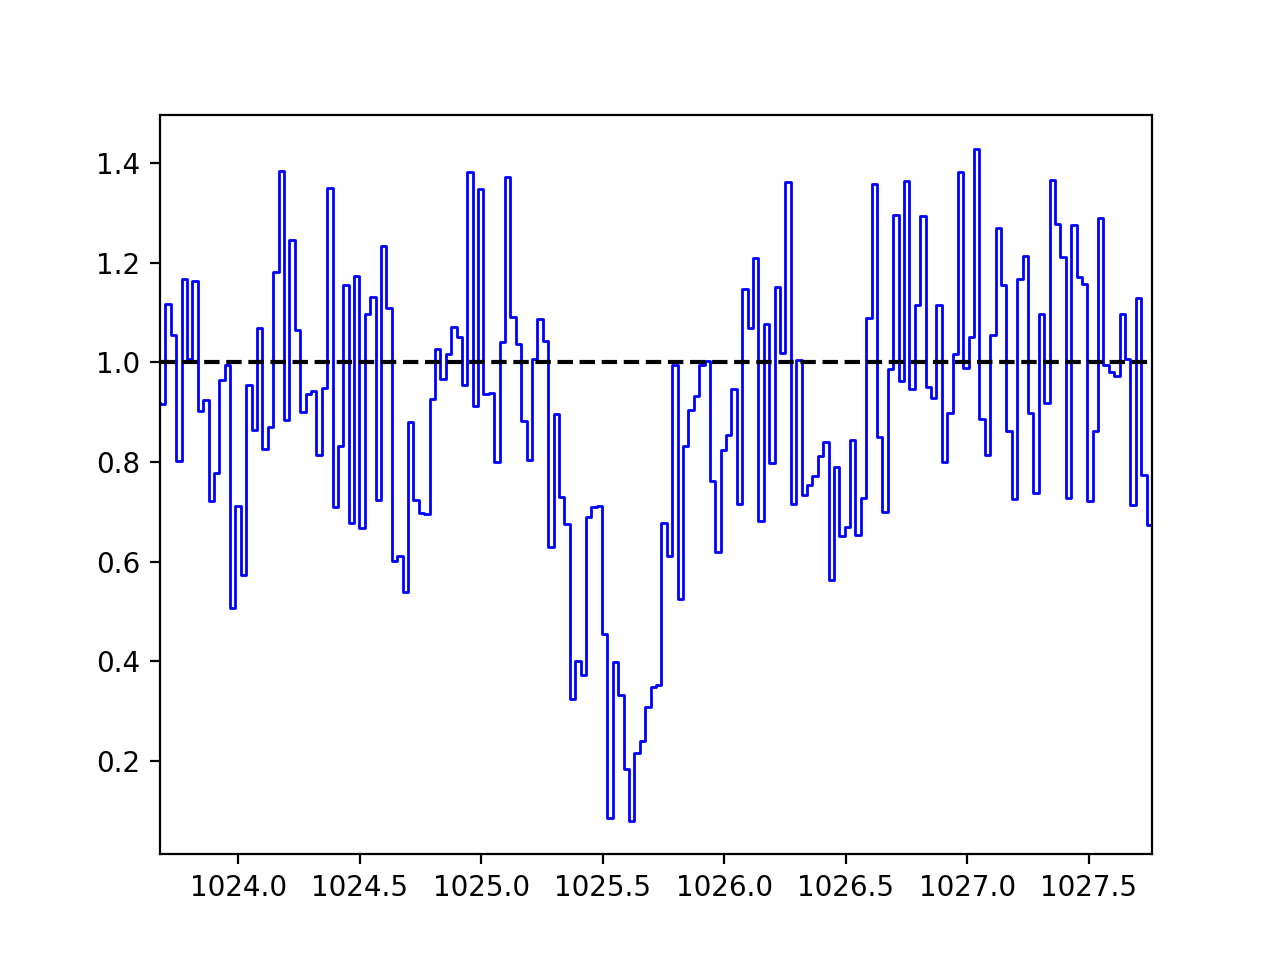

HTML(value='')

In [8]:
from GUIs import interactive_cont_jn as ft
reload(ft)
cont=ft.interactive_cont(s.wave_slice,s.flux_slice,error=s.error_slice)


## Add the handfitted continuum into the rb_spec object

In [13]:
s.fit_continuum(prefit_cont=cont.cont);

Using prefitted continuum...


# Third option for automatic continuum fitting using RANSAC fitting

In [14]:

#s.fit_continuum(mask=[-100,300],domain=xlim,Legendre=3)
s.fit_continuum_ransac(window=199,mednorm=False)
plt.subplot(2,1,1)
plt.step(s.velo,s.flux_slice)
plt.step(s.velo,s.flux_slice/s.fnorm)
plt.xlim(xlim)
plt.subplot(2,1,2)
plt.step(s.velo,s.fnorm)
plt.plot([-600,600],[1,1],'--')
plt.xlim(xlim)

plt.show()


Initializing RANSAC continuum fitter


/Users/bordoloi/opt/anaconda3/envs/zgui/lib/python3.9/site-packages/scipy/signal/_signaltools.py:1545: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/Users/bordoloi/opt/anaconda3/envs/zgui/lib/python3.9/site-packages/scipy/signal/_signaltools.py:1545: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/Users/bordoloi/WORK/python/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


## Compute Equivalent Width and column density for the line profile within a velocity range

<IPython.core.display.Javascript object>


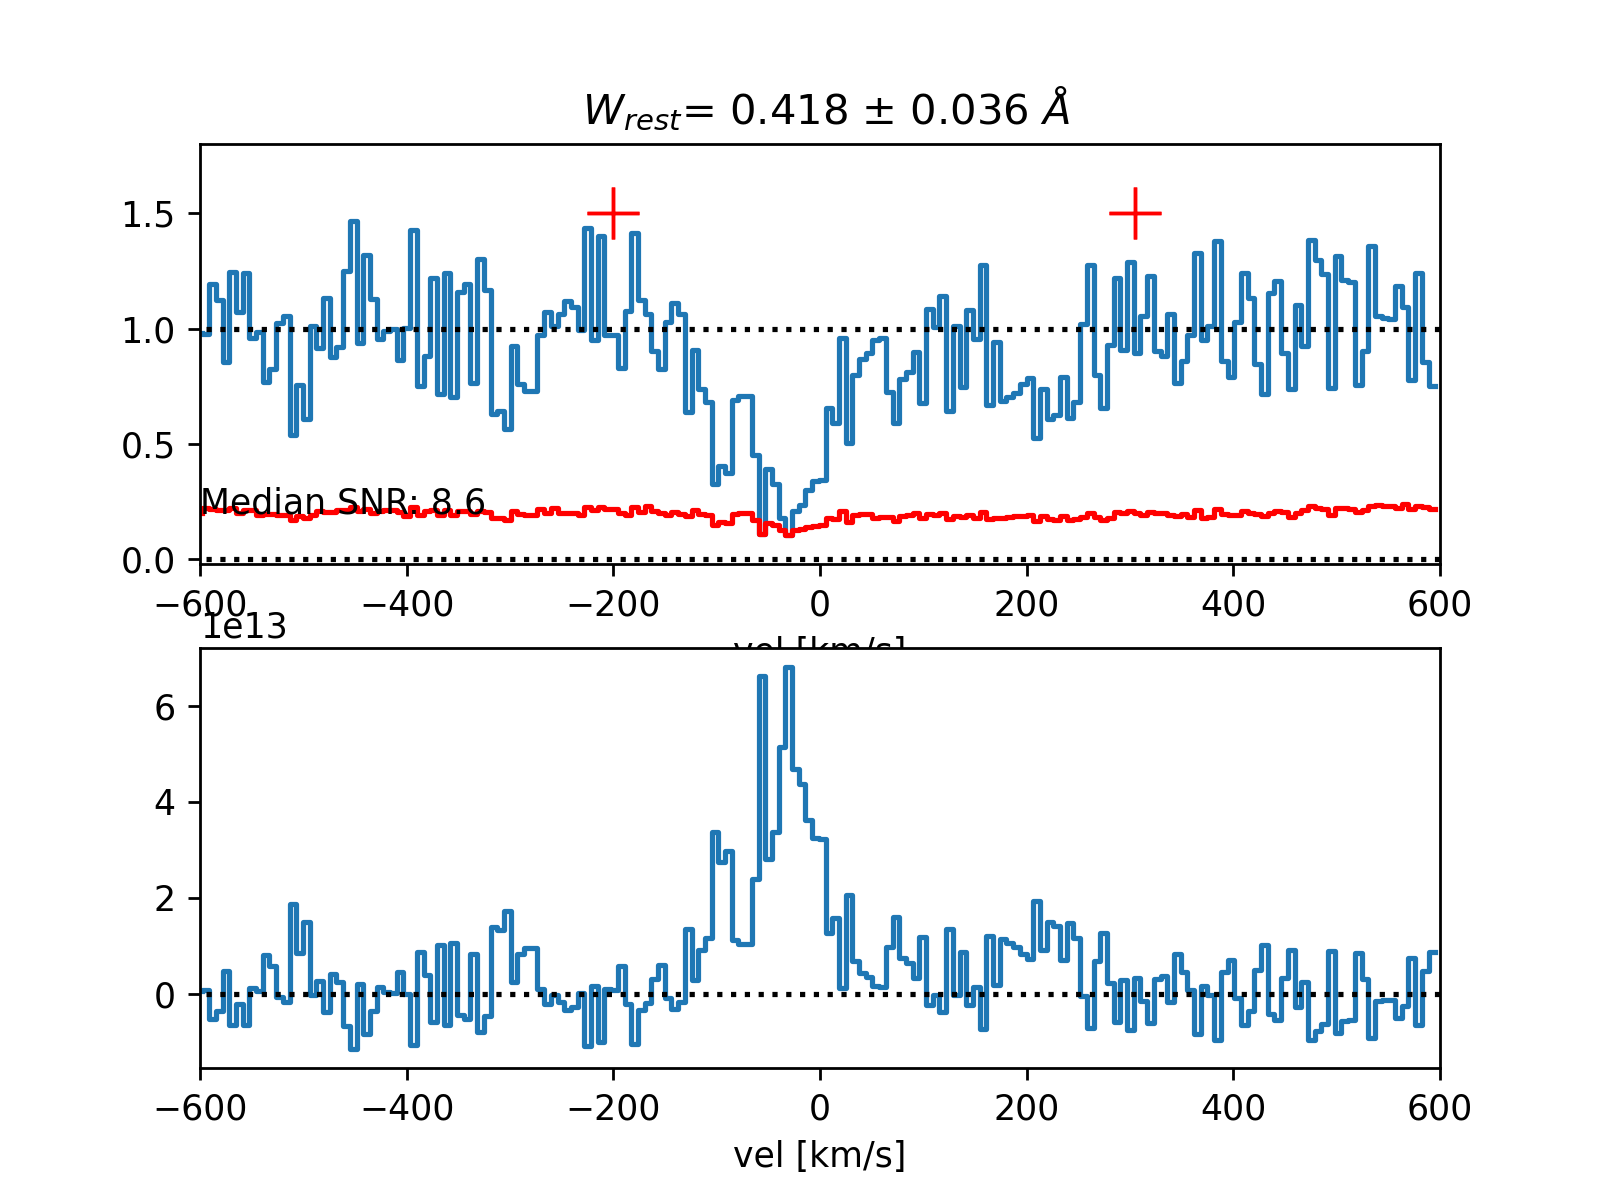

In [7]:
# SNR=True keyword toggles the compute_snr routine to compute signal to noise per PIXEL of the given spectrum.
# Setting plot False will hide the plot below
s.compute_EW(transition,vmin=-200.,vmax=305.,plot=True,SNR=True);


In [8]:
print(s.vel_centroid,s.vel_disp)

-11.913295560786768 61.45310172970429


## Save all the information produced above. 

See rb_spec.py file for details of what is saved.

All entries are saved as a python dictionary in a pickle file. The entries for the saved dictionary are:

<p>zabs= Absorber redshift</p>
<p>wave_slice= sliced observed wavelength vector</p>
<p>flux_slice= sliced observed flux vector</p>
<p>error_slice= sliced velocity spectra </p>
<p>linelist=. LineList used</p>
<p>velo=  sliced velocity vector</p>
<p>cont = Fitted continuum</p>
<p>fnorm= Normalized flux</p>
<p>enorm= Normalized error</p>
<p>trans=  Name of the Transition</p>
<p>fval= fvalue of transition</p>
<p>trans_wave= rest frame wavelength of transition</p>
<p>vmin=     velocity minimum used for equivalent width calculation</p>
<p>vmax=    velocity maximum used for equivalent width calculation</p>
<p>W=    Rest Frame equivalenth width</p>
<p>W_e=  uncertainty on rest frame equivalent width</p>
<p>logN=  AOD column density</p>
<p>logN_e= AOD column density uncertainty</p>
<p>Tau= Apparant optical depth as a function of velocity</p>
<p>vel_centroid= EW weighted velocity centroid</p>
<p>vel_disp= 1 sigma velocity dispersion</p>


#  Option 1: save as pickle file [default]

In [9]:
s.save_slice('outfile.p')

# Option 2: Save as json file

Experimental. DO NOT USE RIGHT NOW

In [10]:
s.save_slice('outfile.json',file_format='json')

# Read saved rb_spec object from json file

In [11]:
from GUIs.rb_spec import load_rb_spec_object as r_load
f='outfile.json'
sp_test=r_load(f)

## Plot the loaded spectrum

<IPython.core.display.Javascript object>


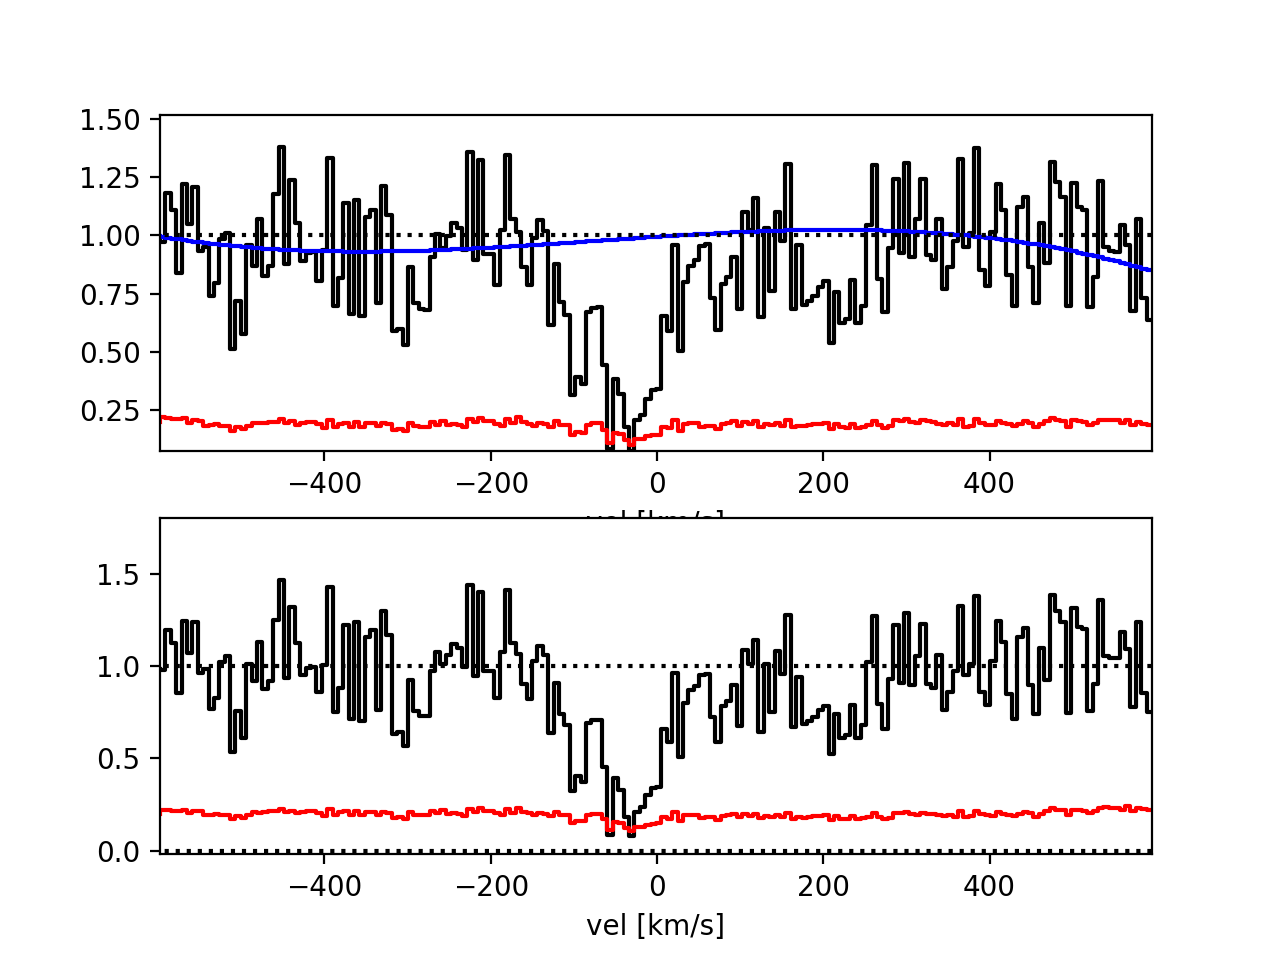

In [18]:
sp_test.plot_slice()

# Read saved rb_spec object from pickle file

In [14]:
import pickle
with open('outfile.p', 'rb') as f:
    sp_test = pickle.load(f)

<IPython.core.display.Javascript object>


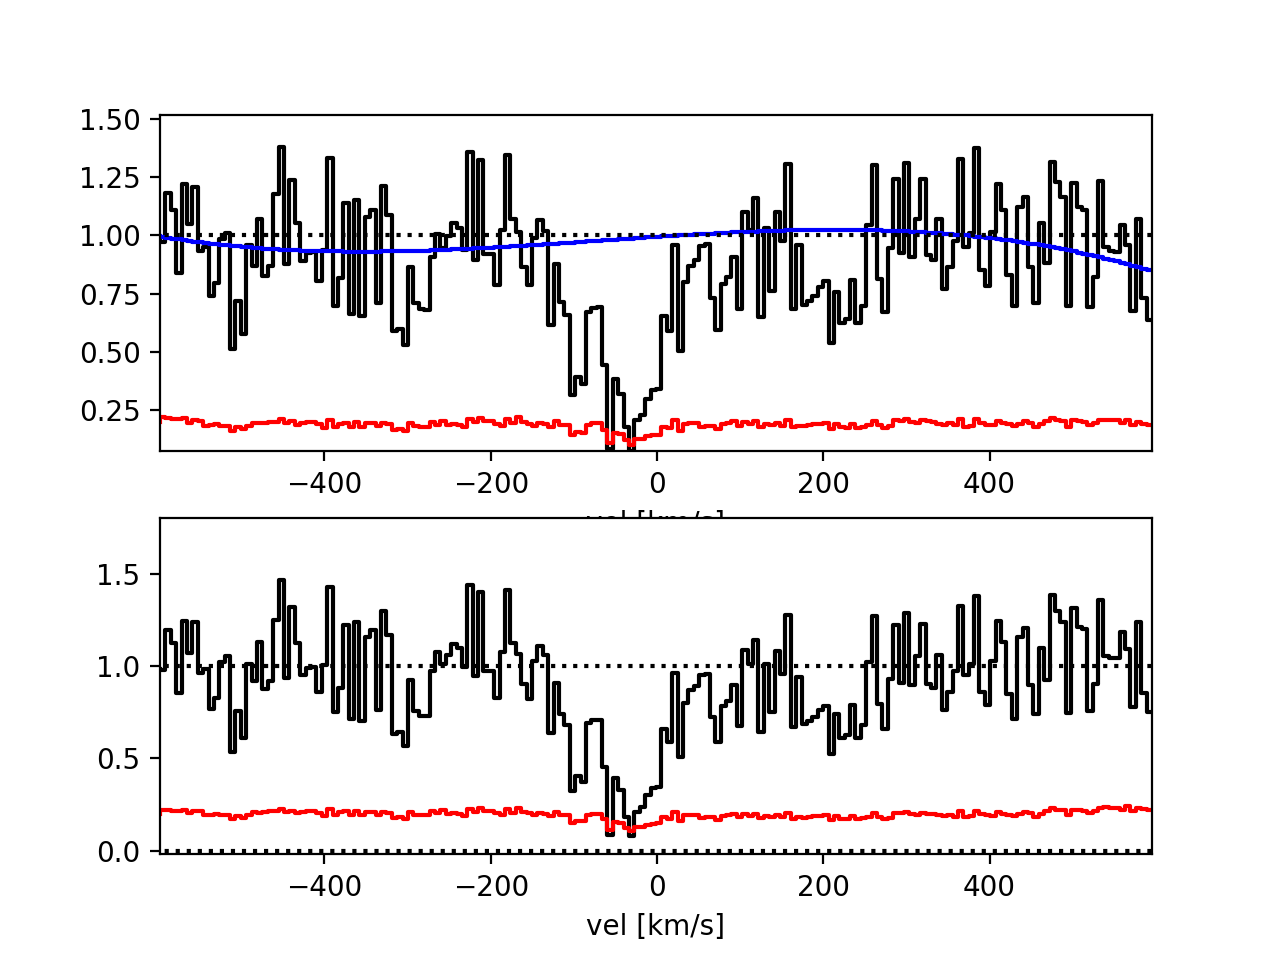

In [17]:
#Plot the loaded spe
sp_test.plot_slice()